<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install dill -q

In [2]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union
import os

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [4]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final_Project.ipynb'

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # GCp
path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [12]:
train_processed.to_pickle("./train_processed.pkl")

In [6]:
train_processed = pd.read_pickle("./train_processed.pkl")

In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [7]:
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [11]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [28]:
doc_lengths

In [8]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [10]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [11]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [12]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [37]:
valid_doc_lengths

In [9]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [14]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [10]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [11]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [12]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [13]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [14]:
def training(model, dataset_loader, optimizer,log_interval,eps_sched, batchs, regularizer,iteration=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'Start training for epoch: {iteration}')
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs        
        
        itr = iteration*(len(dataset_loader.dataset)//batchs) + idx
        optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
                wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#           print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
        
        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [15]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [16]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [17]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [18]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3.55e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(t5model.parameters(), lr=LEARNING_RATE)

In [19]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, hidden_size_model):
    super(GatedFilterLayer, self).__init__()

    self.hidden_size_model = hidden_size_model
    self.projector = nn.Linear(hidden_size_model, 1, bias=False)

#     self.init_weights()

#   def init_weights(self):
#     initrange = 0.1
#     self.projector.bias.data.zero_()
#     self.projector.weight.data.uniform_(-initrange, initrange)

  def forward(self, last_hidden_encoder):
    proj = self.projector(last_hidden_encoder)
    gate = torch.sigmoid(proj)
    hidden_encoder = gate * last_hidden_encoder
    return hidden_encoder, gate

In [20]:
class EncoderModule(nn.Module):

  def __init__(self, T5ForGmodel=None, model_name = 't5-base'):
    super(EncoderModule, self).__init__()

    if T5ForGmodel is None:

      MODEL_NAME = model_name 
      if MODEL_NAME not in ['t5-base','t5-small','t5-large','t5-3b','t5-11b']:
        raise NameError('Name {} is not specified in T5 model names'.format(MODEL_NAME))

      T5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
      self.encoder_model = T5model.encoder
      dmodel = T5model.config.d_model
    else:
      self.encoder_model = T5ForGmodel.encoder
      dmodel = T5ForGmodel.config.d_model

    self.gatefilter = GatedFilterLayer(dmodel)


  def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, head_mask=None, output_hidden_states=False):
    
    if input_ids is None and inputs_embeds is None:
      raise ValueError("You have to specify either input_ids or input_embeds")
    
    if self.encoder_model.config.output_hidden_states or output_hidden_states:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask,
                                      output_hidden_states=True)
    else:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask)
    lst_enc_hidden = encoder_out[0]
    last_hidden_out, gate = self.gatefilter(lst_enc_hidden)

    last_hidden_out = (last_hidden_out, ) + encoder_out[1:] + (gate,)

    return last_hidden_out

In [21]:
class GatedT5ForSummurization(nn.Module):
  
  """
  Gated T5 with Language Model
  
  """

  def __init__(self,t5model=None, MODEL_NAME='t5-base'):
    super(GatedT5ForSummurization, self).__init__()

    self.encoder = EncoderModule(T5ForGmodel=t5model, model_name=MODEL_NAME)
    
    if t5model is None:
        self.decoder = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    else:
        self.decoder = t5model

  def forward(self,input_ids=None, attention_mask=None,
              decoder_input_ids=None,decoder_attention_mask=None,
              decoder_past_key_value_states=None,use_cache=True,lm_labels=None,
              inputs_embeds=None,decoder_inputs_embeds=None, head_mask=None,
              output_hidden_states=False,lamda = 0.0,
             ):

    encoder_outputs = self.encoder(input_ids=input_ids, 
                                   attention_mask=attention_mask,
                                   inputs_embeds=inputs_embeds, 
                                   head_mask=head_mask,
                                   output_hidden_states=output_hidden_states)

    decoder_outputs = self.decoder(
            encoder_outputs=encoder_outputs,
            decoder_input_ids = decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_past_key_value_states = decoder_past_key_value_states,
            use_cache=use_cache,
            lm_labels = lm_labels,
            decoder_inputs_embeds=decoder_inputs_embeds,
            head_mask=head_mask)
        
    # Computing MLE Loss + L1 Norm Reg on LN weight
    if lm_labels is not None:

      Loss_MLE = decoder_outputs[0]
      #weight = self.encoder.gatefilter.projector.weight
      gate = encoder_outputs[-1]
      Loss_gate = torch.sum(gate.squeeze(-1))/(gate.shape[0]*gate.shape[1]) * lamda
      Loss = Loss_MLE + Loss_gate
    
      decoder_outputs = (Loss,) + decoder_outputs[1:]
      
    return decoder_outputs

  def generate(self,
               input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None):

    """
    All possible inputs receive by the generator
    For more details look @ huggingface documentation
    
        input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None
    """

    return self.decoder.generate(input_ids = input_ids, max_length = max_length, min_length = min_length,do_sample = do_sample,
        early_stopping = early_stopping,num_beams = num_beams,temperature= temperature,top_k = top_k,
        top_p = top_p, repetition_penalty = repetition_penalty,bad_words_ids = bad_words_ids,
        bos_token_id  = bos_token_id, pad_token_id  = pad_token_id,eos_token_id = eos_token_id,length_penalty= length_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,num_return_sequences = num_return_sequences,attention_mask = attention_mask,
        decoder_start_token_id = decoder_start_token_id,use_cache = use_cache
    )

In [22]:
model = GatedT5ForSummurization(t5model=t5model)


In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [23]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [24]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [25]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [44]:
Xtrain_trial = X_train.iloc[:50000]
Xvalid_trial = X_valid.iloc[:3600]

In [26]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [25]:
N_EPOCHS = 2
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [27]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run
    
    wandb.init(entity="jp-ishimwe", project="test-summaries") 
#     wandb.init(entity="jp-ishimwe", project="document-summarization-test")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 8
    config.EVAL_BATCH_SIZE = 10
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.2113

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    params = {'params': model.parameters()}
    optimizer = optim.Adam([params], lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")
    #wandb.unwatch(model) 

    maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
    eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))

    for epoch in range(config.N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval,eps_sched, config.BATCH_SIZE, regularizer=config.reg, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb
#         torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model0.pt'))
        torch.save(model.state_dict(), '/root/Projects/model2.pt')


    return train_loss, perplexity, val_loss, outputs


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

In [28]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:44<00:00,  3.05it/s, loss=1.58]


Epoch loss: 1.7417
Perplexity: 1.1716 | Eval loss: 0.1584
--------------


  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:39<00:00,  3.13it/s, loss=1.58]


Epoch loss: 1.6994
Perplexity: 1.1713 | Eval loss: 0.1581
--------------


  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:39<00:00,  3.13it/s, loss=1.58]


Epoch loss: 1.6974
Perplexity: 1.1712 | Eval loss: 0.1580
--------------


Evaluating the gate distributions

In [29]:
outputs[-1].shape

torch.Size([8, 512, 1])

In [30]:
gates = outputs[-1].squeeze(-1) 

In [31]:
gates.mean(dim=1,keepdim=True)

tensor([[0.2737],
        [0.5142],
        [0.5123],
        [0.3169],
        [0.4108],
        [0.5140],
        [0.5034],
        [0.4314]], device='cuda:0', grad_fn=<MeanBackward1>)

In [32]:
values, _ = gates.max(dim=1,keepdim=True)
values

tensor([[0.6321],
        [0.6554],
        [0.6334],
        [0.6614],
        [0.6642],
        [0.6485],
        [0.6474],
        [0.6493]], device='cuda:0', grad_fn=<MaxBackward0>)

In [33]:
vals, _ = gates.min(dim=1,keepdim=True)
vals

tensor([[0.1194],
        [0.3919],
        [0.3619],
        [0.1201],
        [0.1276],
        [0.4012],
        [0.3267],
        [0.1310]], device='cuda:0', grad_fn=<MinBackward0>)

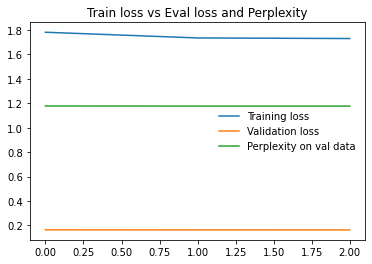

In [46]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [34]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [22]:
model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
model = model.to(device)

In [23]:
#model = torch.load('/root/Projects/model.pt')

In [35]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 8,valid='valid', **argsval)

In [36]:
%time results = generator(model, val_loader)

CPU times: user 7min 46s, sys: 11.5 s, total: 7min 57s
Wall time: 7min 56s


In [75]:
 #input_ids, source_mask, summary_ids, summary_mask = next(iter(val_loader))

#### Visualizing examples

**Example 1**

In [37]:
Xtest_trial.iloc[0,:]['text']

'As the clock ticks hurriedly to NHL s opening night Jan. 19, the Ducks gathered Thursday at Honda Center for an informal practice without a coach partially to gauge where their conditioning is before the 48 game sprint of a labor stoppage shortened season.\n\n From what I saw, the guys have taken care of themselves and I think we ll be ready to go, said left wing Matt Beleskey, who spent three months of the layoff playing for the Coventry Blaze in England the team covering his expenses with him funding his own insurance.\n\nDucks veteran Teemu Selanne assessed players such as Beleskey, defenseman Luca Sbisa, centers Nick Bonino and Andrew Cogliano and right wing Bobby Ryan, who played games over the break and hold an edge over others such as Selanne, who relied on mountain biking, running and informal practices to stay conditioned.\n\n The way things are now in this game, everyone comes to camp in great shape, Selanne said. But game shape comes from good practices and games. It doesn 

In [38]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'As the clock ticks hurriedly to NHL andrsquo s opening night Jan. 19, the Ducks gathered Thursday at Honda Center for an informal practice without a coach partially to gauge where their conditioning is before the 48 game sprint of a labor stoppage shortened season.'

In [39]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'As the clock ticks hurriedly to NHL.com ne Kopitar of The Kings injured his knee. Right next, Ryan said. It very well could have been me.'

**Example 2**

In [40]:
Xtest_trial.iloc[1,:]['text']

'After class action king Bill Lerach avowed in an affidavit last month that his firm never had an agreement to pay a Florida attorney 10 referral fees, that lawyer responded with a declaration listing names of 15 cases that he says he referred to the firm since 1998 and for which, he claims, Lerach s firm or its predecessor paid him in full. The Florida lawyer, Bruce Murphy, is seeking 10 of a 2.5 million fee Lerach Coughlin and its co lead counsel received in a 2004 settlement in a class action against Tut Systems, which is now a unit of Motorola MOT .\n\n Lerach is under scrutiny in connection with an unrelated criminal probe that has already led to the indictment of the firm he formerly co ran, Milberg Weiss Bershad and Schulman, and two of that firm s name partners. All defendants have pleaded not guilty. The probe appears to be at a critical stage, and Lerach, 61, has acknowledged that he is considering retirement. See posts here and here. \n\nThe earlier back and forth in the ref

In [41]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'See update at end After class action king Bill Lerach avowed in an affidavit last month that his firm never had an agreement to pay a Florida attorney 10 referral fees, that lawyer responded with a declaration listing names of 15 cases that he says he referred to the firm since 1998 and for'

In [42]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'after class action king Bill Lerach avowed in an attorney last month that his firm never had an agreement to pay., that neither he nor the named plaintiffs were ever informed of the 2004 settlement of the case and that neither I or the named plaintiff was ever told about the 2004 deal'

**Example 3**

In [43]:
Xtest_trial.iloc[3,:]['text']

'After surviving Russian Ultras, England supporters now have encounter with Euro 2016 s friendliest fans\n\nFOLLOWING the bloody Battle of Marseille England s loyal following now have a very different encounter with Europe s friendliest fans.\n\nRoy Hodgson s Three Lions meet Iceland tomorrow night in the exclusive coastal city of Nice a fortnight after their fans were left battered by Russian ultras.\n\nBut the Vikings of Iceland promise the clash will be trouble free as they say they prefer hugs to hooliganism .\n\nSome 27,000 Iceland fans have travelled to France, almost 10 percent of the Nordic island s 330,000 strong population.\n\nNo smaller country has ever featured at a Euro finals.\n\nAnd their supporters say they plan to make the most of the experience.\n\nAfter the Group F tie with Hungary pockets of Iceland fans gathered in Marseille s Vieux Port district to chant Boom Boom Hoooo! , leaping in unison on the Hoooo! .\n\n It s our Viking song, synchronised and terrifying, lau

In [44]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'FOLLOWING the bloody Battle of Marseille England s loyal following now have a very different encounter with Europe s friendliest fans. Roy Hodgson sThree Li'

In [45]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'FOLLOWING the bloody Battle of Marseille England s loyal following now have very different encounter with Europe and Russia fans in the worst violence at Euro 2016 since 1998 World Cup, prompting police to respond with tear gas.'

**Example 4**

In [46]:
Xtest_trial.iloc[4,:]['text']

'The chairman of the House Judiciary Committee said Thursday that the way the U.S. grants asylum to immigrants may need to be changed in the wake of the Boston Marathon bombings.\n\nAccused Boston Marathon bombers Tamerlan and Dzhokhar Tsarnaev are ethnic Chechen brothers from Russia who came to the United States about a decade ago with their parents. The family was granted asylum.\n\n We certainly will view that as a part of overall comprehensive immigration reform, Rep. Bob Goodlatte, R Va., told reporters Thursday, adding that no decisions have been made on possible changes to the asylum process.\n\nGoodlatte didn t specify what might need to be changed in the process, only saying it s something that bears examination in the wake of the Boston bombings. So do with other aspects of the U.S. immigration system, including the naturalization process by which immigrants become U.S. citizens, Goodlatte said.\n\n People getting asylum because they are in the minority, but engaging in aggre

In [47]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'The chairman of the House Judiciary Committee said Thursday that the way the U.S. grants asylum to immigrants may need to be addressed after the Boston Marathon bombing.'

In [48]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'The chairman of the House Judiciary Committee said Thursday that the way U.S grants asylum to immigrants may need changes in response after the Boston bombings.'

**Example 5**

In [49]:
Xtest_trial.iloc[5,:]['text']

'Photos Ferguson protests across U.S. 35 photos\n\nPhotos Ferguson protests across U.S. 35 photos\n\nFerguson protests across U.S. Students at Jackson State University in Jackson, Mississippi, participate in the walkout on December 1.\n\nPhotos Ferguson protests across U.S. 35 photos\n\nFerguson protests across U.S. Protesters join in the walkout at Union Square in New York on December 1.\n\nPhotos Ferguson protests across U.S. 35 photos\n\nFerguson protests across U.S. Students at Clayton High School in Clayton, Missouri, take part in a die in protest in the school cafeteria on December 1.\n\nPhotos Ferguson protests across U.S. 35 photos\n\nFerguson protests across U.S. Boston Arts Academy students and supporters march in downtown Boston on December 1.\n\nPhotos Ferguson protests across U.S. 35 photos\n\nFerguson protests across U.S. Members of the St. Louis Rams raise their arms as they walk onto the field in St. Louis before their NFL game against the Oakland Raiders on Sunday, Nov

In [50]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'Nobody said racism made sense. But for a city systematically kept unequal, it has made money, Dorothy A. Brown says.'

In [51]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'Photos Ferguson protests across U.S, 35 photos Ferguson demonstration in New York during the Macy a Thanksgiving Day Parade on Thursday and November 26'

**Example 6**

In [52]:
Xtest_trial.iloc[6,:]['text']

'FIVE years after his parents divorce, the 14 year old author of a paper on the subject concluded We all know that marriage is the major cause of divorce. But this is no joke especially where children are concerned. \n\nWith children of divorce constituting one of the fastest growing segments of the population, legal and medical practitioners gathered in White Plains last weekend to assess divorce and its effect on children.\n\nThe one day institute, The Effects of Divorce and Custody on the Child, was sponsored by the Westchester division of New York Hospital, Cornell Medical Center. The conference attracted nearly 200 participants, many drawn by a panel that included Dr. Albert Solnit, Sterling Professor of Pediatrics and Psychiatry at the Yale University School of Medicine, and Dr. Judith S. Wallerstein, professor of social welfare at the University of California, Berkeley, who holds a doctorate in clinical psychology.\n\nThe program, in addition to lectures and workshops, featured 

In [53]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'FIVE years after his parents divorce, the 14 year old author of a paper on the subject concluded We all know that marriage is the major cause of divorce. But this is no joke especially where children are concerned. With children of divorce constituting one of the fastest growing segments of the population, legal and medical practitioners gathered in White Plains last weekend to assess divorce and its effect on children. The one day institute, The Effects of Divorce and Custody on the Child, was sponsored by the Westchester division of New York Hospital, Cornell Medical Center. The conference attracted nearly 200 participants, many drawn by a panel that included Dr. Albert Solnit, Sterling Professor of Pediatrics and '

In [54]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'FIVE years after his parents divorce, the 14 year old author of a paper onthe subject concluded We all know that marriage is The major cause. But thisis no joke especially where children are concerned'

**Example 7**

In [55]:
Xtest_trial.iloc[7,:]['text']

'WASHINGTON Eager to soothe tensions, President Barack Obama and Chinese President Hu Jintao shared an unusual and intimate dinner Tuesday night to discuss the strains and common goals that define the complicated relations between the two rival powers.\n\nThe private dinner, in the Old Family Dining Room in the White House residence, came amid disputes over China s currency, trade and human rights policies and a search for cooperation on national security. It preceded a planned pomp filled gala for Hu on Wednesday night and illustrated Obama s careful mix of warmth and firmness for the leader of a nation that is at once the largest U.S. competitor and most important potential partner.\n\nAlso at the dinner were national security adviser Tom Donilon and Secretary of State Hillary Clinton. Hu brought along two top Chinese officials. Underscoring the desire for candor, the White House said there were no official note takers at the dinner and offered no readout of the discussions.\n\nFor H

In [56]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'While currency manipulation is topic one for many Americans awaiting the Chinese president s delegation, other topics like intellectual property theft, government contracting and indigenous innovation are also of concern to U.S. businesses and manufacturers.'

In [57]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'Eager to soothe tensions, President Barack Obama and Chinese president Hu Jintao shared an unusual dinner Tuesday night to discuss the strain he promised would be trademark of his foreign policy.'

**Example 8**

In [58]:
Xtest_trial.iloc[8,:]['text']

'Staff Sgt. Robert Bales entered guilty pleas to 16 counts of murder.\n\n CNN Count by count, Army Staff Sgt. Robert Bales on Wednesday admitted to gunning down 16 civilians in a 2012 rampage through two villages near his outpost in southern Afghanistan.\n\nBales pleaded guilty to more than 30 criminal charges, including 16 premeditated murder counts, in a hearing before a military judge. He admitted to slipping away from his outpost in southern Afghanistan and going on a house to house killing spree in two nearby villages in March 2012, a massacre that further strained ties between American troops and their Afghan allies.\n\nThe move spares the 39 year old Bales the prospect of a death sentence in the killings. But he was unable to offer the judge, Col. Jeffery Nance, an explanation for his actions.\n\n I ve asked that question a million times since then. There s not a good reason in the world for the horrible things I did, Bales replied, according to Drew Mikkelson of CNN affilliate 

In [59]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'Hoping to avoid a death sentence, a U.S. Army sergeant entered guilty pleas to 16 murder counts Wednesday in connection with a 2012 massacre of Afghan civilians.'

In [60]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'Count by count, Army Staff Sgt. Robert Bales entered guilty pleas to 16 counts of murder in a hearing before prosecutors at Joint Base Lewis McChord, near Tacom A, Washington'

**Example 9**

In [61]:
Xtest_trial.iloc[9,:]['text']

'Tali Lennox Fruchtmann and Ian Jones\n\n\nNearly three days after the boyfriend of Tali Lennox Fruchtmann the daughter of singer Annie Lennox went missing after a\n\n, authorities say his body may have been recovered.\n\nMonday afternoon, a male body was found that matches Jones description, the Dutchess County Sheriff s Office told PEOPLE in a statement, adding that while there is a strong possibility that the body recovered is that of Mr. Jones, it remains only a possibility at this time. \n\nAn autopsy to determine the death and identification is scheduled for Tuesday, and the search for Jones has been suspended.\n\nVisual artist Lennox Fruchtmann, 22, and model photographer Jones, 32, were kayaking in the Hudson River near Poughkeepsie, New York, Saturday morning when they capsized.\n\n The current in the Hudson River is very strong, and we believe the current played a role in the kayak capsizing, and once the two got in the water it was difficult for them to stay together, Dutche

In [62]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'Lennox s daughter Tali Lennox Fruchtmann s boyfriend Ian Jones went missing Saturday after their kayak capsized'

In [63]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'Nearly three days after the boyfriend of Tali Lennox Fruchtmann the daughterof singer Annie leennom went missing after a capsize, authorities say his body may have been recovered.'

**Example 10**

In [64]:
Xtest_trial.iloc[15,:]['text']

'America s devotion to eggnog the frothy festive beverage of milk, sugar, and eggs, served hot or cold and oftentimes spiked with rum, brandy, or other liquors is strong, Army strong. Some have even rioted for their right to indulge in the holiday treat.\n\nIn what has been dubbed the Eggnog Riot of 1826, 70 cadets at West Point were involved in a seasonal skirmish after drinking vats of homemade eggnog at a Christmas celebration on campus in defiance of the superintendent of West Point s strict rules about alcohol consumption. The students carried on the eggnog excess of years prior, which led to the court martial of several participants.\n\nNowadays, eggnog, customized, entirely legal, and less scandalous, abounds from sea to shining sea at office parties, bars, and homes. While traditional eggnog can be found abroad, nations around the world have their own version of the sweet creamy concoction. But does a nog by any other name taste as sweet?\n\nChilean cola de mono literally monke

In [65]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'A global guide to the iconic mugs of holiday cheer.'

In [66]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'America s devotion to eggnog the sweet festive beverage of milk, sugar and eggs is strong, Army Strong. The Netherlands or Holland advocat are served with local tokka beans, star anisese, and an elegant, semi frozen coffee cloud'

### Performance

In [67]:
!pip3 install rouge
from rouge import Rouge

In [68]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [69]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [70]:
get_score(results)

{'rouge1': 0.3040002495869519,
 'rouge2': 0.15648412408440554,
 'rougeL': 0.2525259402210672}

In [ ]:
{'rouge1': 0.26842624944505433,
 'rouge2': 0.11997541219146737,
 'rougeL': 0.21621404321691318} #0.21

In [ ]:
{'rouge1': 0.3251555298232545,
 'rouge2': 0.17724507880716306,
 'rougeL': 0.2734545655096767}

In [71]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.272821556293817,
 'rouge-2': 0.1424978509052513,
 'rouge-l': 0.25330000211649917}

In [ ]:
{'rouge-1': 0.23891854897729273,
 'rouge-2': 0.10855931785640041,
 'rouge-l': 0.21982563644064748}

In [ ]:
{'rouge-1': 0.2934569607894014,
 'rouge-2': 0.16207342615668757,
 'rouge-l': 0.2762959592687011} #0.2

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])